**Problem:**
In 2004, an estimated 17.1 million people died from cardiovascular disease, accounting for 29% of all global deaths. Coronary heart disease was responsible for approximately 7.2 million of these fatalities. Any method that can help detect indicators of heart disease.

The subject is particularly interesting to machine learning researchers since it includes the categorization of audio sample data, and discriminating between classes of interest is difficult. Data is collected in real-world scenarios and usually includes all types of background noise. The distinctions between heart sounds corresponding to various cardiac ailments might be quite subtle and difficult to distinguish. Classifying this type of data requires incredibly robust classifiers.

In [1]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.16.1
keras version:  3.3.3


In [3]:
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12 

In [4]:
set_a=pd.read_csv("C:/Users/esruj/Desktop/heart sound analysis and classification/set_a.csv")
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [5]:
set_a_timing=pd.read_csv("C:/Users/esruj/Desktop/heart sound analysis and classification/set_a_timing.csv")
set_a_timing.head()

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992


In [6]:
set_b=pd.read_csv("C:/Users/esruj/Desktop/heart sound analysis and classification/set_b.csv")
set_b.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [7]:
#merge both set-a and set-b
frames = [set_a, set_b]
train_ab=pd.concat(frames)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_a/artifact__201012172012.wav,normal,noisynormal
freq,656,1,351,120


In [8]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


Min samples per category =  19
Max samples per category =  351


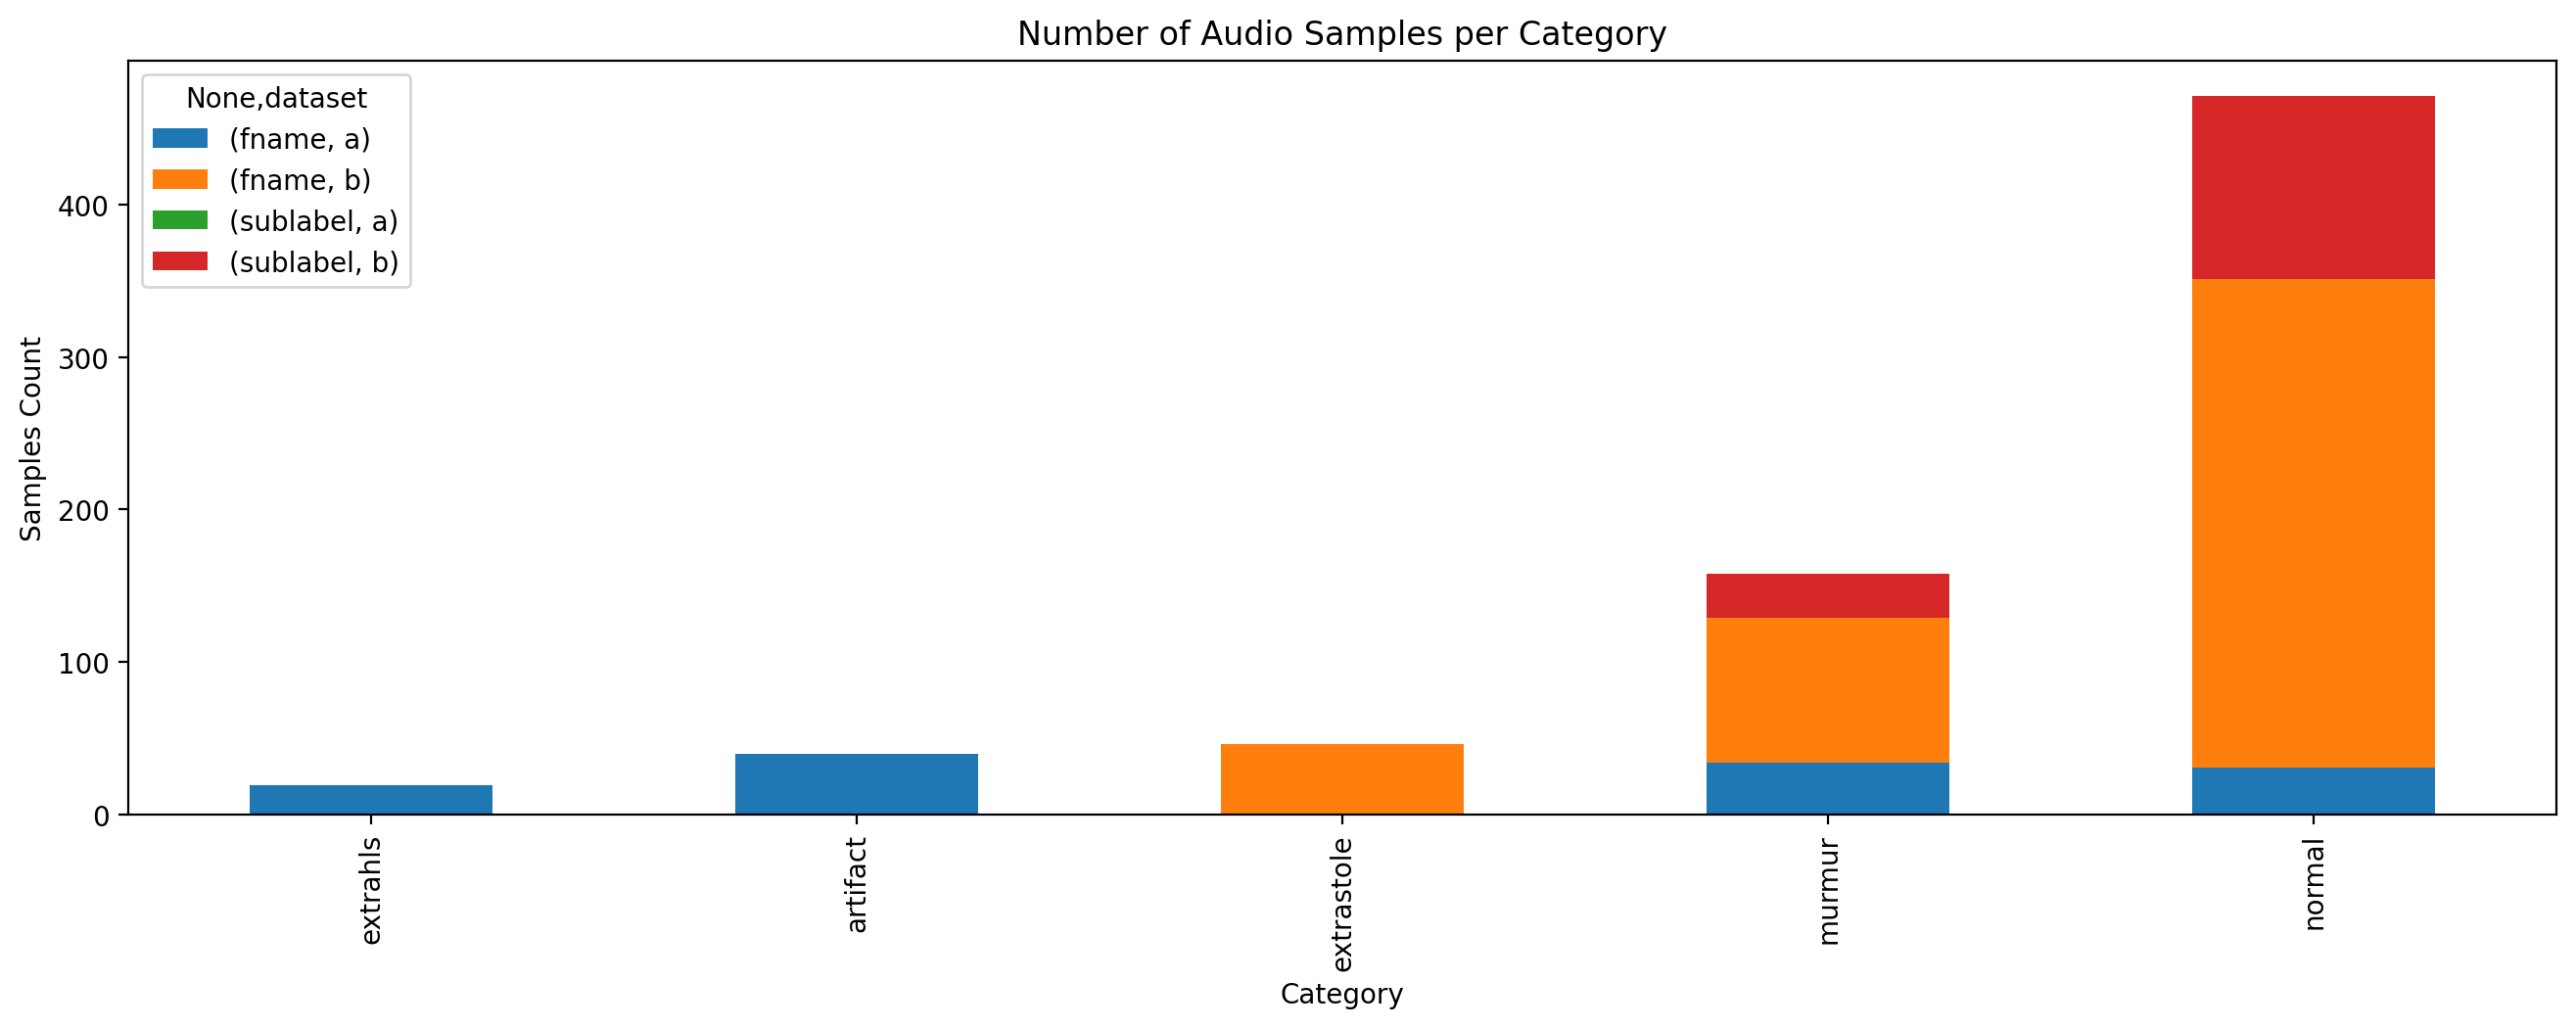

In [9]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [10]:
print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

Minimum samples per category =  19
Maximum samples per category =  351


<h1>Lets understand the categories</h1>

**1. Normal category**

Normal, healthy heart sounds are included in this group. These may include noise in the last second of the recording as the gadget is removed from the body. They may contain a wide range of background noises (from traffic to radios). They may also comprise random noises like as breathing or the microphone brushing against clothing or skin. A normal heart sound has a clear "lub dub, lub dub" rhythm, with the time between "lub" and "dub" less than the time from "dub" to the next "lub" (when the heart rate is less than 140 beats per minute).(Source: Rita Getz.)

In [84]:
normal_file="C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/normal__201106111136.wav"

In [85]:
# Load use wave 
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [86]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


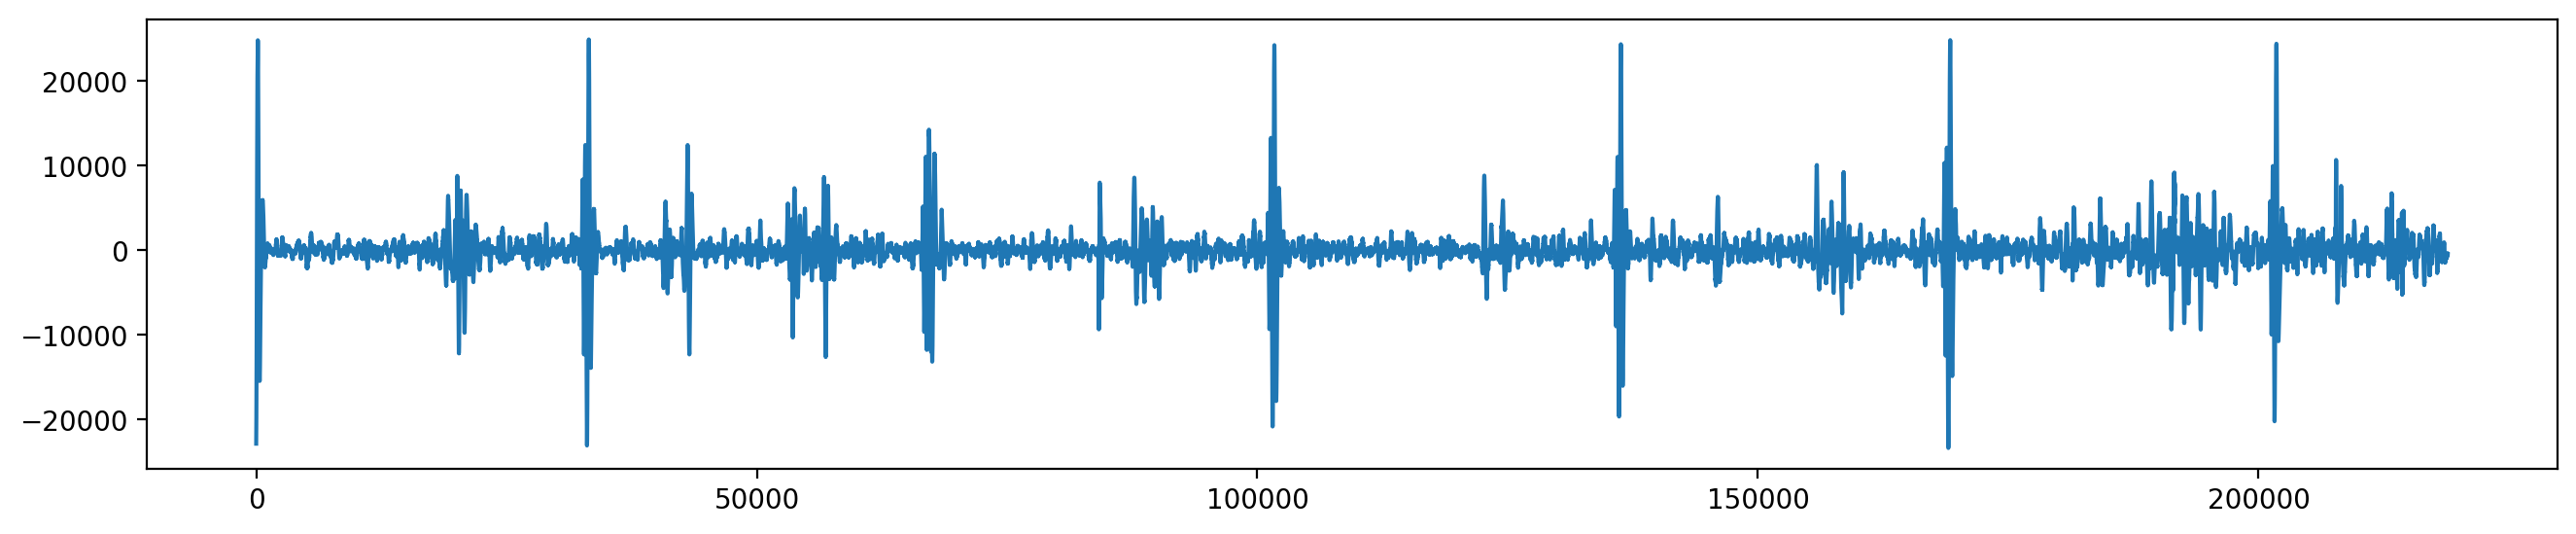

In [87]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [88]:
# Load using Librosa
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


**2. Murmur**

Heart murmurs appear as a "whooshing, roaring, rumbling, or turbulent fluid" sounds in one of two temporal locations: (1) between "lub" and "dub", or (2) between "dub" and "lub". They can be symptoms of a variety of heart conditions, some of which are severe. There will still be "lub" and "dub". One of the things that perplexes non-medically trained persons is that murmurs occur between lub and dub, rather than on lub and not on dub.(Source: Rita Getz.)

In [90]:
# murmur case
murmur_file="C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [94]:
# Load use wave 
import wave
wav = wave.open(murmur_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  349958
Duration =  7.935555555555555


In [95]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


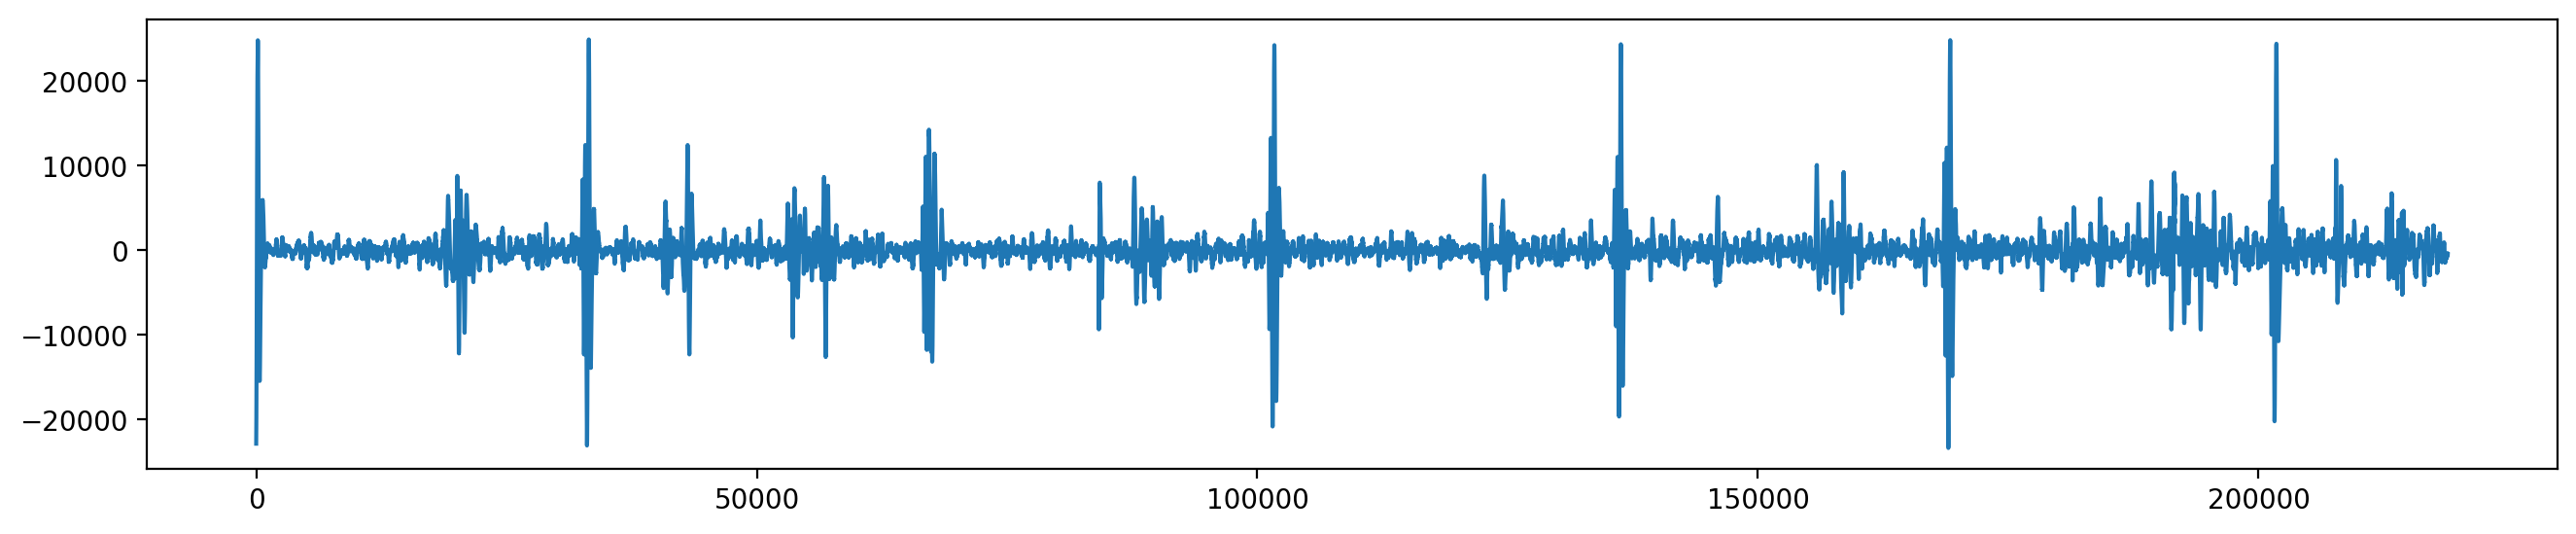

In [96]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

**3.Artifact**

In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [100]:
# Artifact case
murmur_file="C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201012172012.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [101]:
# Load use wave 
import wave
wav = wave.open(murmur_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  396900
Duration =  9.0


In [102]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


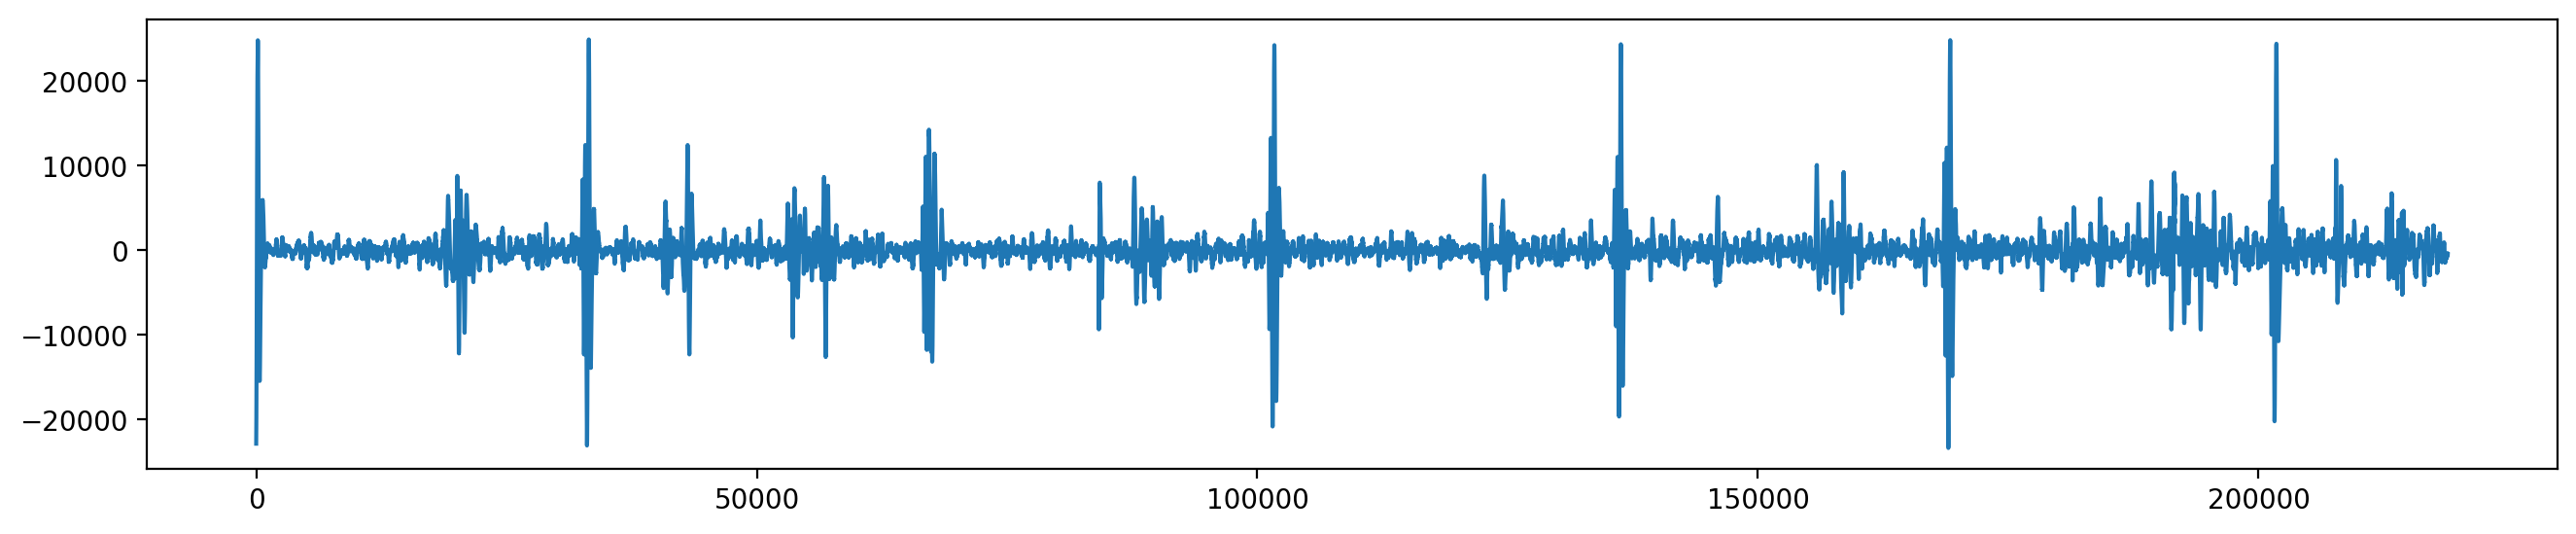

In [103]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

**mfccs**

In [80]:
# Here's a sample generate mfccs from a wave file
normal_file="C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y2, sr=sr)
print (mfccs)

[[-4.91420502e+02 -4.87638245e+02 -4.79105225e+02 ... -4.86290619e+02
  -2.41096008e+02 -1.16379829e+02]
 [ 6.62601013e+01  7.23027191e+01  8.50155945e+01 ...  7.43507690e+01
   1.11789825e+02  1.05937531e+02]
 [ 5.50427208e+01  6.25961533e+01  7.69400330e+01 ...  6.50083389e+01
   3.11908226e+01  2.54833889e+01]
 ...
 [ 4.96952236e-01 -3.12932909e-01 -8.31087232e-01 ...  4.82063890e-02
   1.70232344e+00  2.69635606e+00]
 [ 1.42843103e+00  8.13924372e-01  4.88648236e-01 ...  1.28484678e+00
   1.08420610e+00  2.32498264e+00]
 [ 1.89722323e+00  1.59520221e+00  7.71509647e-01 ...  2.23820066e+00
   1.68410301e-01  1.62813759e+00]]


In [21]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.19826889e+01 -1.28008362e+02 -3.90283020e+02 ... -3.50583923e+02
  -3.54071747e+02 -3.58922791e+02]
 [ 1.13760162e+02  1.16467430e+02  1.35765884e+02 ...  1.49861938e+02
   1.57678711e+02  1.58090637e+02]
 [ 2.19686203e+01  2.43651562e+01  1.18758545e+01 ...  2.01783695e+01
   1.87385635e+01  2.76223526e+01]
 ...
 [-1.37634134e+00 -7.92668581e-01 -2.06323290e+00 ...  2.91040277e+00
  -1.41850114e+00  1.55428171e+00]
 [-2.64943266e+00 -2.29667544e+00 -3.48219705e+00 ...  1.37113619e+00
   3.46585214e-02 -1.58002543e+00]
 [-4.14034891e+00 -4.16323566e+00 -1.68562305e+00 ...  4.19539571e-01
   6.43803954e-01 -3.50527716e+00]]


In [22]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

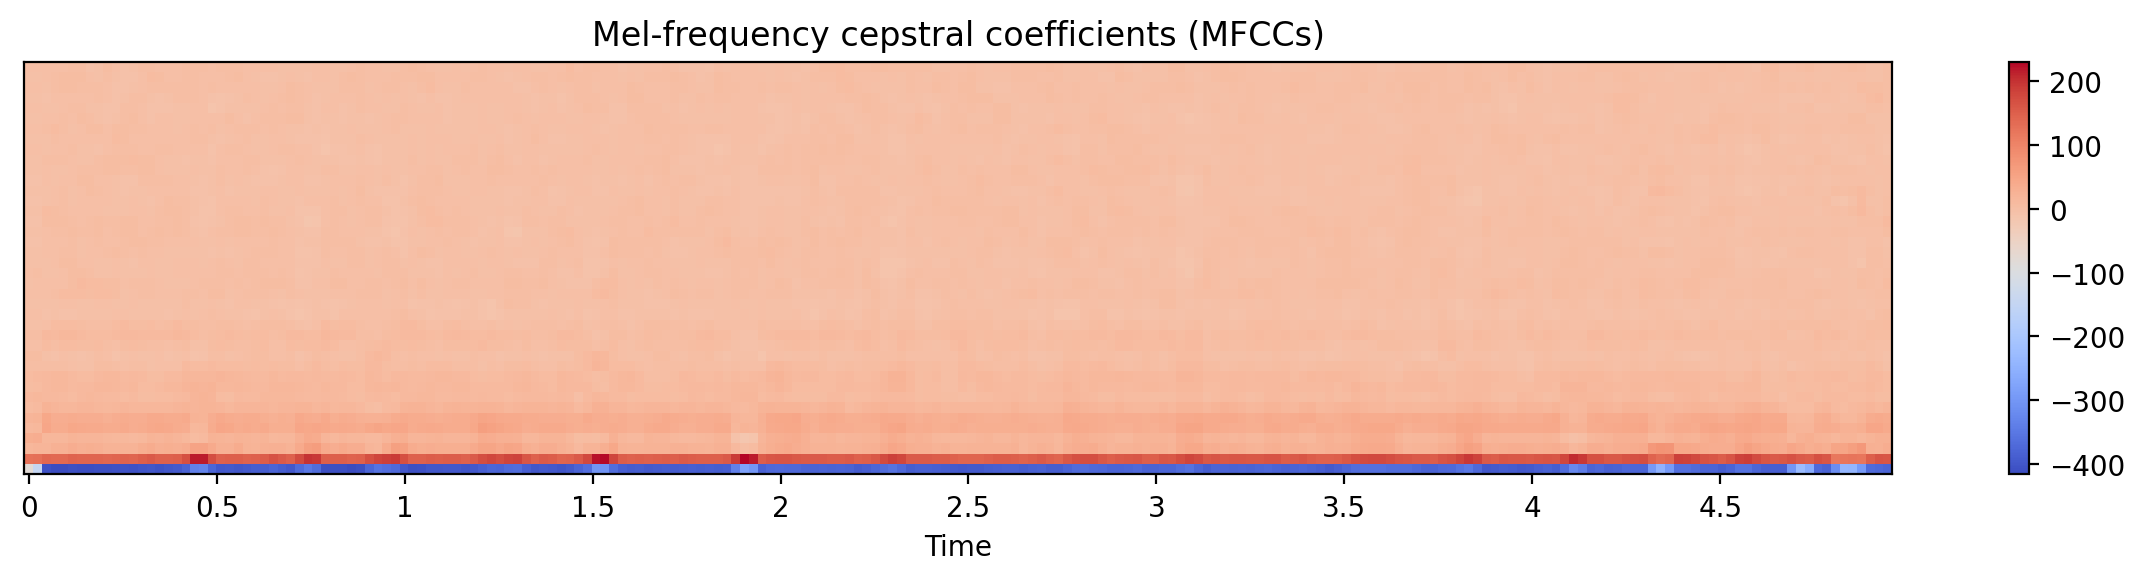

In [23]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

**Loding data**

In [31]:
print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))

Number of training examples= 832   Number of classes= 6


Loading od the audio data file will be based on content from directory since each filename is associate with the category type. hence, we can use csv file for cross reference check. Based on directory content approach will be more flexible.

In [32]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.19826889e+01 -1.28008362e+02 -3.90283020e+02 ... -3.50583923e+02
  -3.54071747e+02 -3.58922791e+02]
 [ 1.13760162e+02  1.16467430e+02  1.35765884e+02 ...  1.49861938e+02
   1.57678711e+02  1.58090637e+02]
 [ 2.19686203e+01  2.43651562e+01  1.18758545e+01 ...  2.01783695e+01
   1.87385635e+01  2.76223526e+01]
 ...
 [-1.37634134e+00 -7.92668581e-01 -2.06323290e+00 ...  2.91040277e+00
  -1.41850114e+00  1.55428171e+00]
 [-2.64943266e+00 -2.29667544e+00 -3.48219705e+00 ...  1.37113619e+00
   3.46585214e-02 -1.58002543e+00]
 [-4.14034891e+00 -4.16323566e+00 -1.68562305e+00 ...  4.19539571e-01
   6.43803954e-01 -3.50527716e+00]]


In [33]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
# print (mfccs)

In [34]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
            print("**",mfccs)
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [35]:
import os
import librosa
import numpy as np

def audio_norm(data):
    max_abs_value = np.max(np.abs(data))
    if max_abs_value > 0:
        data = data / max_abs_value
    return data

def load_file_data(folder, file_names, duration=12, sr=16000):
    input_length = sr * duration
    data = []
    
    for file_name in file_names:
        sound_file = os.path.join(folder, file_name)
        print("Loading file:", sound_file)
        
        try:
            # Load the audio file
            X, sr = librosa.load(sound_file, sr=sr, duration=duration, res_type='kaiser_fast')
            dur = librosa.get_duration(y=X, sr=sr)
            
            # Pad the audio to the fixed duration
            if round(dur) < duration:
                print("Fixing audio length:", file_name)
                X = librosa.util.fix_length(X, size=input_length)
                
            # Normalize the audio
            X = audio_norm(X)
            
            # Extract MFCC features
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T, axis=0)
            
            # Reshape and append the feature
            feature = np.array(mfccs).reshape([-1, 1])
            data.append(feature)
        
        except Exception as e:
            print("Error encountered while parsing file:", file_name, "\nError:", e)
            
    return data

In [36]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [37]:
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12 

In [38]:
# load dataset-a, keep them separate for testing purpose
import os, fnmatch

A_folder='C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201012172012.wav
Fixing audio length: artifact__201012172012.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201105040918.wav
Fixing audio length: artifact__201105040918.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201105041959.wav
Fixing audio length: artifact__201105041959.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201105051017.wav
Fixing audio length: artifact__201105051017.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201105060108.wav
Fixing audio length: artifact__201105060108.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_a/artifact__201105061143.wav
Fixing audio length: artifact__201105061143.wav
Loading file: C:/Users/esruj/Desktop/heart sound ana

In [39]:
%%time
# load dataset-b, keep them separate for testing purpose 
B_folder='C:/Users/esruj/Desktop/heart sound analysis and classification/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir('C:/Users/esruj/Desktop/heart sound analysis and classification/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_b/normal_noisynormal_101_1305030823364_B.wav
Fixing audio length: normal_noisynormal_101_1305030823364_B.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_b/normal_noisynormal_101_1305030823364_E.wav
Fixing audio length: normal_noisynormal_101_1305030823364_E.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_b/normal_noisynormal_104_1305032492469_A.wav
Fixing audio length: normal_noisynormal_104_1305032492469_A.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_b/normal_noisynormal_105_1305033453095_A.wav
Fixing audio length: normal_noisynormal_105_1305033453095_A.wav
Loading file: C:/Users/esruj/Desktop/heart sound analysis and classification/set_b/normal_noisynormal_105_1305033453095_C.wav
Fixing audio length: normal_noisynormal_105_1305033453095_C.wav
Loading file: C:/Users/esruj/Desktop/heart sound a

In [40]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [41]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [42]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (585,)
data size of the array: : 585
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  2340
0

audio data shape:  (585, 40, 1)
data size of the array: : 23400
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  93600

training data shape:  (473, 40, 1)
training label shape:  (473, 3)

validation data shape:  (53, 40, 1)
validation label shape:  (53, 3)

test data shape:  (59, 40, 1)
test label shape:  (59, 3)


**Modelling**

In [43]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from tensorflow.keras.utils import to_categorical
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import CosineSimilarity

# Define your classes
CLASSES = ['class1', 'class2', 'class3']  # Example classes, replace with actual classes

print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True, input_shape=(40, 1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adamax(),
    metrics=['acc', 'mse', 'mae', 'mape', CosineSimilarity(axis=1)]
)

model.summary()

Build LSTM RNN model ...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,411 (114.89 KB)

 Trainable params: 29,411 (114.89 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Assuming x_train, y_train, x_val, y_val are already defined
# Set constants
MAX_PATIENT = 12
MAX_EPOCHS = 100
MAX_BATCH = 32
best_model_file = "./best_model_trained.keras"
train_model_file = "./checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"

# Define callbacks
callbacks = [
    ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
    ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True),
    TensorBoard(log_dir='./logs')
]

print("Training started... please wait.")

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=MAX_BATCH,
    epochs=MAX_EPOCHS,
    verbose=1,  # Set to 1 to show progress
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

print("Training finished!")

Training started... please wait.
Epoch 1/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.4627 - cosine_similarity: 0.5954 - loss: 1.0650 - mae: 0.4363 - mape: 218129792.0000 - mse: 0.2152
Epoch 1: loss improved from inf to 1.01925, saving model to ./best_model_trained.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - acc: 0.4728 - cosine_similarity: 0.5982 - loss: 1.0593 - mae: 0.4348 - mape: 217395152.0000 - mse: 0.2140 - val_acc: 0.6415 - val_cosine_similarity: 0.6761 - val_loss: 0.8900 - val_mae: 0.3875 - val_mape: 193760640.0000 - val_mse: 0.1816 - learning_rate: 0.0010
Epoch 2/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.5887 - cosine_similarity: 0.6776 - loss: 0.8723 - mae: 0.3787 - mape: 189371984.0000 - mse: 0.1805
Epoch 2: loss improved from 1.01925 to 0.85464, saving model to ./best_model_trained.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.5873 - cosine_similarity: 0.6780 - loss: 0.8701 - mae: 0.3773 - mape: 188664256.0000 - mse: 0.1803 - val_acc: 0.660

In [105]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  70 %
model test data score        :  73 %
model validation data score  :  75 %


<Figure size 2200x1000 with 0 Axes>

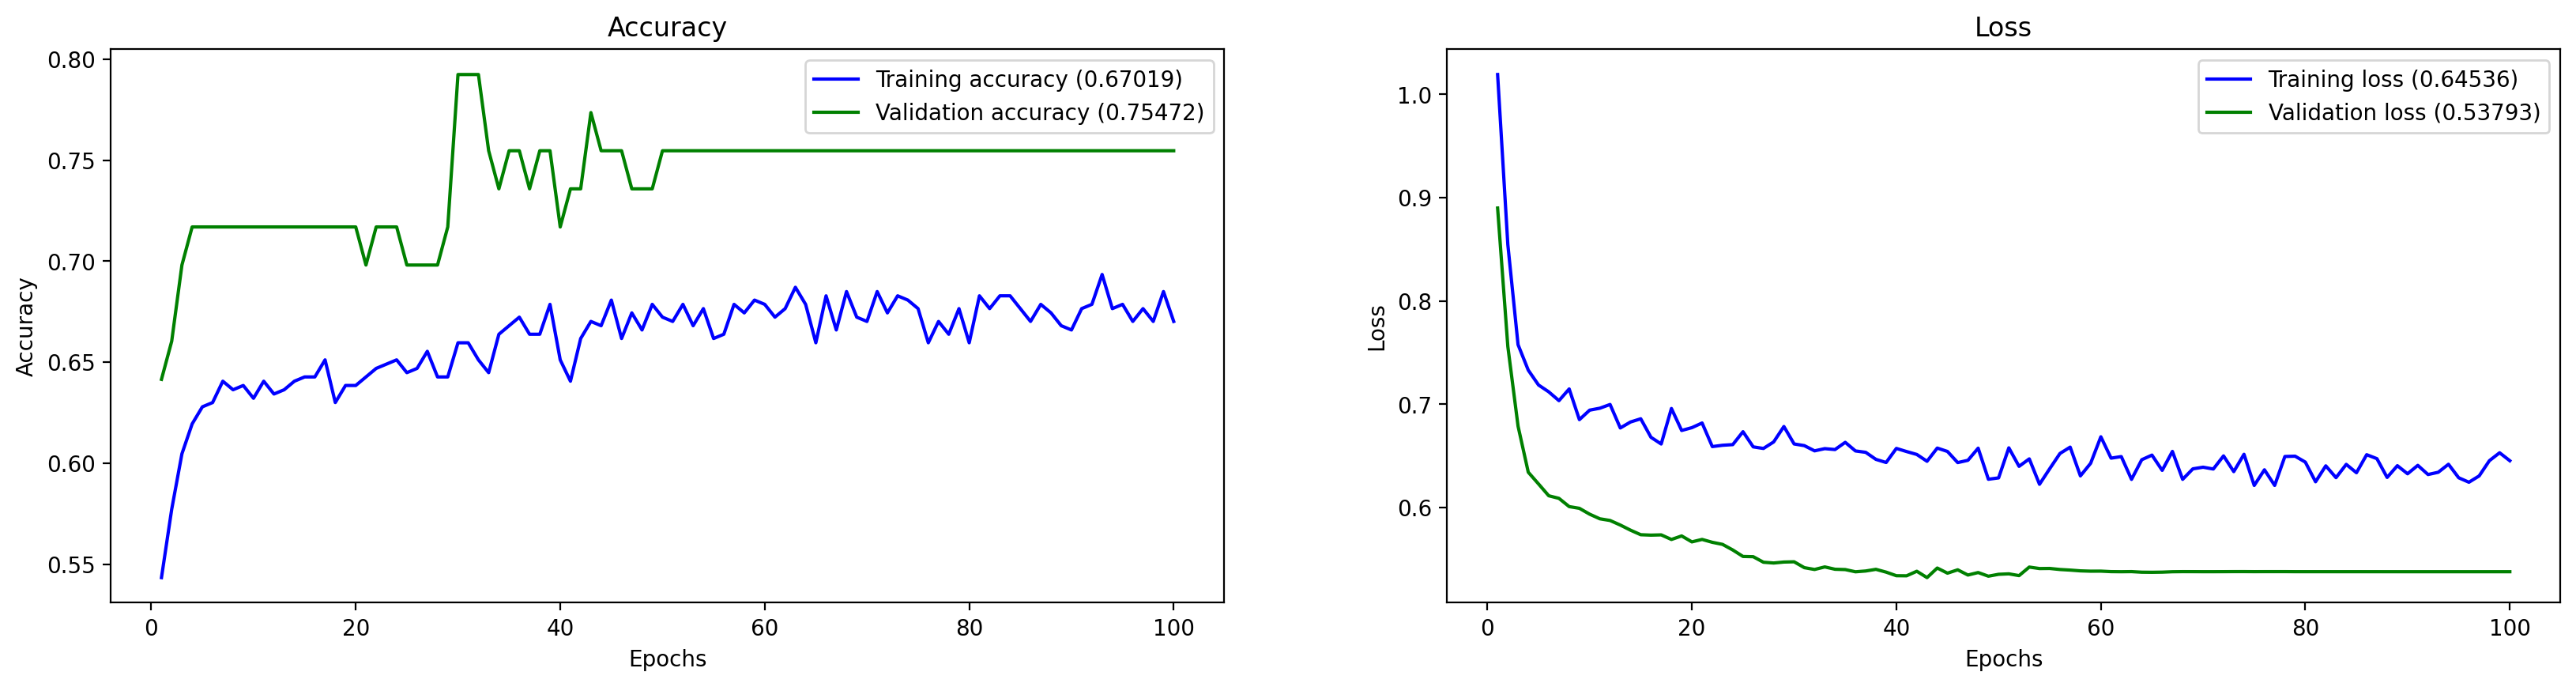

CPU times: total: 328 ms
Wall time: 761 ms


In [106]:
%%time
#Plot Keras History
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [107]:
#Predict class probabilities for test data
y_pred_prob = model.predict(x_test, batch_size=32)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Print prediction for the second test sample
print("Prediction test return:", y_pred[1], "-", int_to_label[y_pred[1]])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction test return: 2 - normal


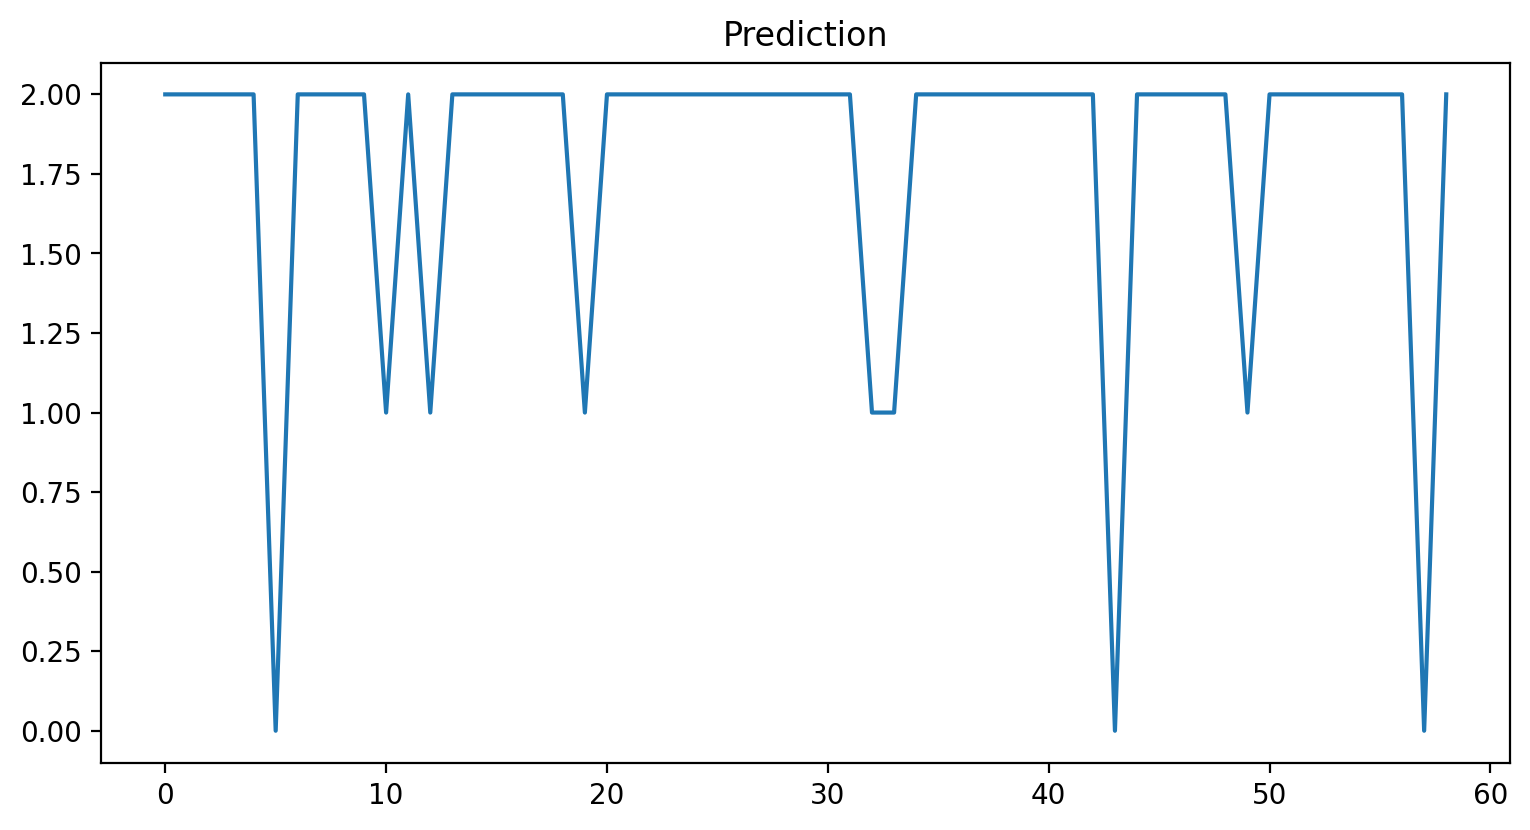

In [50]:
plt.figure(1,figsize=(20,10))
# plot Classification Metrics: Accuracy 
plt.subplot(221, title='Prediction')
plt.plot(y_pred)
plt.show()

In [51]:
print (best_model_file)

./best_model_trained.keras


In [73]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()
# load weights
model.load_weights(best_model_file)
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 40, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,411 (114.89 KB)

 Trainable params: 29,411 (114.89 KB)

 Non-trainable params: 0 (0.00 B)

Created model and loaded weights from file


In [108]:
import numpy as np

# Make a prediction
y_pred_prob = model.predict(x_test, batch_size=32)
y_pred = np.argmax(y_pred_prob, axis=1)

# Check scores
scores = model.evaluate(x_test, y_test, verbose=0)
print("Model evaluation accuracy: ", round(scores[1] * 100), "%")

# Print prediction for the second test sample
print("Prediction test return:", y_pred[1], "-", int_to_label[y_pred[1]])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Model evaluation accuracy:  73 %
Prediction test return: 2 - normal
